In [1]:
# onnx has to be imported before torch (some bug)
import onnx 
import torch 

In [2]:
# Import model into FINN with ModelWrapper
from qonnx.core.modelwrapper import ModelWrapper

ready_model_filename = "finn_lenet.onnx"
model_for_sim = ModelWrapper(ready_model_filename)

/home/rstar900/finn/deps/qonnx/src/qonnx/core/modelwrapper.py:93: UserWarning: Some old-style domain attributes were automatically converted to new-style,
                i.e. domain=finn to domain=qonnx.custom_op.<general|fpgadataflow|...>
  warnings.warn(


In [3]:
# Print out the available member functions of ModelWrapper
dir(model_for_sim)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_model_proto',
 'analysis',
 'check_all_tensor_shapes_specified',
 'check_compatibility',
 'cleanup',
 'find_consumer',
 'find_consumers',
 'find_direct_predecessors',
 'find_direct_successors',
 'find_producer',
 'find_upstream',
 'fix_float64',
 'get_all_tensor_names',
 'get_finn_nodes',
 'get_initializer',
 'get_metadata_prop',
 'get_node_index',
 'get_nodes_by_op_type',
 'get_non_finn_nodes',
 'get_tensor_datatype',
 'get_tensor_fanout',
 'get_tensor_layout',
 'get_tensor_shape',
 'get_tensor_sparsity',
 'get_tensor_valueinfo',
 'graph',
 'is_fork_node',
 'is_join_node',
 'make_empty_exec_context',
 'make_new_valuein

In [4]:
# Extract various information using some of these functions 
# Note that the output tensor is (as of yet) marked as a float32 value, even though we know the output is binary 
# This will be automatically inferred by the compiler in the next step when we run the InferDataTypes transformation
from qonnx.core.datatype import DataType

finnonnx_in_tensor_name = model_for_sim.graph.input[0].name
finnonnx_out_tensor_name = model_for_sim.graph.output[0].name
print("Input tensor name: %s" % finnonnx_in_tensor_name)
print("Output tensor name: %s" % finnonnx_out_tensor_name)
finnonnx_model_in_shape = model_for_sim.get_tensor_shape(finnonnx_in_tensor_name)
finnonnx_model_out_shape = model_for_sim.get_tensor_shape(finnonnx_out_tensor_name)
print("Input tensor shape: %s" % str(finnonnx_model_in_shape))
print("Output tensor shape: %s" % str(finnonnx_model_out_shape))
finnonnx_model_in_dt = model_for_sim.get_tensor_datatype(finnonnx_in_tensor_name)
finnonnx_model_out_dt = model_for_sim.get_tensor_datatype(finnonnx_out_tensor_name)
print("Input tensor datatype: %s" % str(finnonnx_model_in_dt.name))
print("Output tensor datatype: %s" % str(finnonnx_model_out_dt.name))
print("List of node operator types in the graph: ")
print([x.op_type for x in model_for_sim.graph.node])

Input tensor name: inp.1
Output tensor name: 90
Input tensor shape: [1, 3, 32, 32]
Output tensor shape: [1, 10]
Input tensor datatype: FLOAT32
Output tensor datatype: FLOAT32
List of node operator types in the graph: 
['MultiThreshold', 'Add', 'Mul', 'Conv', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MaxPool', 'Conv', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MaxPool', 'Shape', 'Gather', 'Unsqueeze', 'Concat', 'Reshape', 'MatMul', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MatMul', 'Mul', 'Div', 'Add', 'Mul', 'MultiThreshold', 'Mul', 'MatMul', 'Mul']


In [5]:
# Network preparation: Tidy-up transformations
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants

model_for_sim = model_for_sim.transform(InferShapes())
model_for_sim = model_for_sim.transform(FoldConstants())
model_for_sim = model_for_sim.transform(GiveUniqueNodeNames())
model_for_sim = model_for_sim.transform(GiveReadableTensorNames())
model_for_sim = model_for_sim.transform(InferDataTypes())
model_for_sim = model_for_sim.transform(RemoveStaticGraphInputs())

verif_model_filename = "finn_lenet_verification.onnx"
model_for_sim.save(verif_model_filename)

In [6]:
# Visualize in Netron
from finn.util.visualization import showInNetron

showInNetron(verif_model_filename)

Serving 'finn_lenet_verification.onnx' at http://0.0.0.0:8081


In [7]:
 # We will now do verification to make sure our transformed model performs exactly as the Brevitas one

In [7]:
# Necessary Imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Import for Brevitas
import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant

In [8]:
# transform PILImage images from dataset to tensors
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


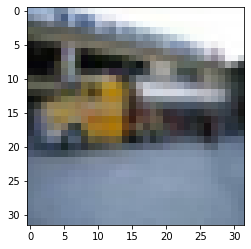

truck


In [9]:
# Just showing images to check if it works

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Get some random training image
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
# Now we redefine the Brevitas low precision Lenet5 network
class LowPrecisionNet(nn.Module):
    
    def __init__(self):
        super(LowPrecisionNet, self).__init__()
        
        # Input quantization layer
        self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)
        
        # 2 convolution layers and Quantized ReLU between each of them
        # 3 input image channel, 6 output channels, 5x5 convolution kernel
        self.conv1 = qnn.QuantConv2d(3, 6, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(6, 16, 5, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        
        # 3 fully connected layers
        # an affine operation: y = Wx + b
        self.fc1 = qnn.QuantLinear(16 * 5 * 5, 120, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.fc2 = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu4 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.fc3 = qnn.QuantLinear(84, 10, bias=False, weight_bit_width=3)
        
        
    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.relu2(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.shape[0], -1) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:
# Load weights into the Brevitas model (Need to save the model as torch .pth as well beforehand)
brevitas_model = LowPrecisionNet()
trained_state_dict = torch.load("finn_lenet_state_dict.pth")
brevitas_model.load_state_dict(trained_state_dict, strict=False)

<All keys matched successfully>

In [25]:
# Benchmarking Brevitas model over the whole dataset

correct = 0
total = 0

# Not calculating gradients as we are not training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = brevitas_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %') 

brevitas_model_accuracy = 100 * correct // total;

Accuracy of the network on the 10000 test images: 49 %


In [26]:
import finn.core.onnx_exec as oxe

# Doing some transformations before data could be passed to the FINN model
finnonnx_in_tensor_name = model_for_sim.graph.input[0].name
finnonnx_model_in_shape = model_for_sim.get_tensor_shape(finnonnx_in_tensor_name)
finnonnx_out_tensor_name = model_for_sim.graph.output[0].name

# Now benchmarking the FINN's verification model over the same dataset
correct = 0
total = 0

# Not calculating gradients as we are not training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # Transforming input data before passing to FINN
        images = images.detach().numpy()
        
        # reshape to expected input (add 1 for batch dimension)
        images = images.reshape(finnonnx_model_in_shape)
        
        # create the input dictionary
        input_dict = {finnonnx_in_tensor_name : images}
        
        # run with FINN's execute_onnx
        output_dict = oxe.execute_onnx(model_for_sim, input_dict)
        
        #get the output tensor
        outputs = output_dict[finnonnx_out_tensor_name]
        
        # convert to tensor (for evaluation)
        outputs = torch.tensor(outputs)
        
        # benchmarking
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %') 

finn_model_accuracy = 100 * correct // total;

Accuracy of the network on the 10000 test images: 49 %


In [27]:
# print verification results
if brevitas_model_accuracy == finn_model_accuracy:
    print("Verification Success!")
else:
    print("Verification failed")

Verification Success!
